# Fitting data with `easyCore`

The `easyCore` library is designed to enable the model-dependent analysis, using a purely Python interface and give access to a range of optimization algorithms. 
We can perform the analysis of any data for which we have a closed-form mathematical description, the parameters of which we want to refine. 

In this short demonstration, we will look at how `easyCore` can be used to analyse the toy problem of data that follows a quadratic relationship. 
We will manufacture some quadratic data to work with below. 
`easyCore` comes packages with an internal version of `numpy` that we will use throughout and set the random seed to ensure reproducibility in this example. 


In [10]:
from easyCore import np

np.random.seed(123)

a_true = -0.9594
b_true = 7.294
c_true = 3.102

N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 3 * np.random.rand(N)
y = a_true * x ** 2 + b_true * x + c_true
y += np.abs(y) * 0.2 * np.random.randn(N)

With our data created, lets have a look at it.

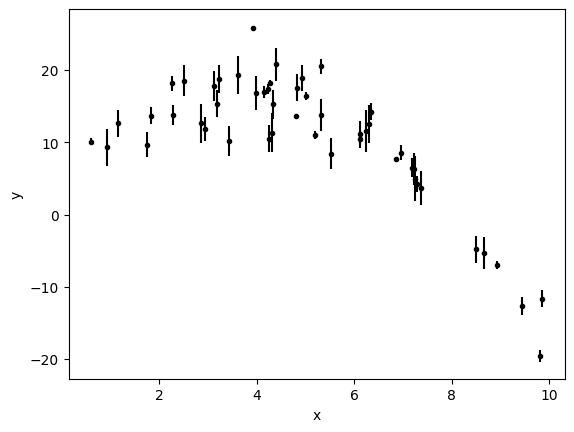

In [27]:
import matplotlib.pyplot as plt

plt.errorbar(x, y, yerr, marker='.', ls='', color='k')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

The data looks reasonable, so we can start to construct the `easyCore` analysis model. 

This will consist of three parameters, which we will call `a`, `b` and `c`. 
We will give these initial values that are the same as the true values defined above and cause we want to optimize these parameters, we will set them not to be fixed. 

In [28]:
from easyCore.Objects.Variable import Parameter

a = Parameter(name='a', value=a_true, fixed=False)
b = Parameter(name='b', value=b_true, fixed=False)
c = Parameter(name='c', value=c_true, fixed=False)

The mathematical model that we are looking to optimize is

```{math}
:label: quadratic
y = a x ^ 2 + b x + c.
```

We can create a function that implements this mathematical model as shown below. 
Note, that it is necessary to include the `*args`, and `**kwargs` arguments and to use the `raw_value` property of each parameter. 

In [29]:
def math_model(x, *args, **kwargs):
    return a.raw_value * x ** 2 + b.raw_value * x + c.raw_value

We can now plot the initial guess of this mathematical model along with the experimental data.  

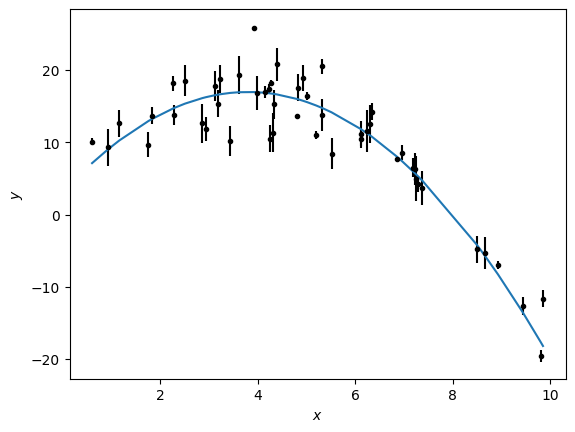

In [30]:
plt.errorbar(x, y, yerr, marker='.', ls='', color='k')
plt.plot(x, math_model(x), '-')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

In [15]:
from easyCore.Objects.ObjectClasses import BaseObj

In [16]:
o = BaseObj('line', a=a, b=b, c=c)

In [17]:
from easyCore.Fitting.Fitting import Fitter

In [18]:
f = Fitter(o, fit_func)

In [19]:
res = f.fit(x, y, weights=yerr)

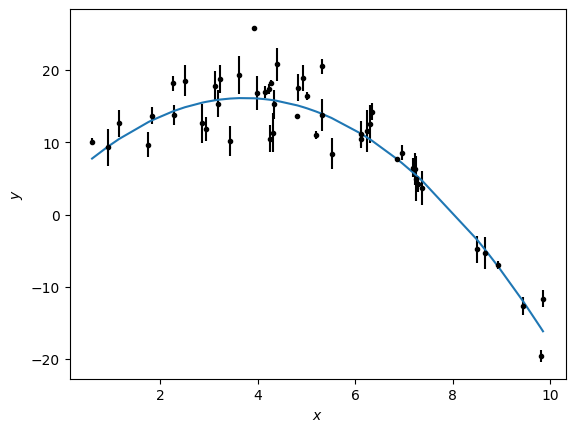

In [22]:
plt.errorbar(x, y, yerr, marker='.', ls='', color='k')
plt.plot(x, fit_func(x), '-')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

In [23]:
a, b, c

(<Parameter 'a': -0.86+/-0.08, bounds=[-inf:inf]>,
 <Parameter 'b': 6.4+/-0.8, bounds=[-inf:inf]>,
 <Parameter 'c': 4.2+/-1.9, bounds=[-inf:inf]>)

In [24]:
a_true, b_true, c_true

(-0.9594, 7.294, 3.102)

In [25]:
from scipy.stats import multivariate_normal

In [26]:
mv = multivariate_normal(mean=y, cov=np.diag(yerr))

In [29]:
def log_likelihood(theta, x, y, yerr):
    a.value, b.value, c.value = theta
    model = f.evaluate(x)
    logl = mv.logpdf(model)
    return logl

In [39]:
from scipy.stats import uniform

In [50]:
prior1 = uniform(loc=-5.0, scale=0.5 + 5.0)
prior2 = uniform(loc=0, scale=10) 
prior3 = uniform(loc=-20, scale=50 + 20)

def log_prior(theta):
    a, b, c = theta
    return sum([prior1.pdf(a), prior2.pdf(b), prior3.pdf(c)])

In [51]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [52]:
f.evaluate(x)

array([  7.89122172,   9.63229648,  10.7747159 ,  13.22655666,
        13.47206576,  14.81092113,  14.8476326 ,  15.37689604,
        16.03941089,  16.1501342 ,  16.37702312,  16.42767496,
        16.47933135,  16.6156379 ,  16.67513741,  16.63661487,
        16.60947281,  16.49783149,  16.42380478,  16.39671734,
        16.3913817 ,  16.34310833,  16.31083256,  16.25201533,
        15.55790767,  15.51492575,  15.28477511,  15.09463959,
        14.6414269 ,  14.29883678,  14.29068323,  13.68028506,
        11.37838666,  11.29573801,  10.79420116,  10.46408492,
        10.29983817,   7.63349903,   6.95213754,   5.53303054,
         5.34245448,   5.21262991,   4.91339772,   4.31970785,
        -4.3004003 ,  -5.80361787,  -8.32421235, -13.41073211,
       -17.36989412, -17.90671441])

In [53]:
res.p.values()

dict_values([-0.9086004632605406, 6.83909946627578, 3.6707005735350258])

In [54]:
import emcee

pos = list(res.p.values()) + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 500, progress=True);

100%|██████████| 500/500 [00:37<00:00, 13.47it/s]


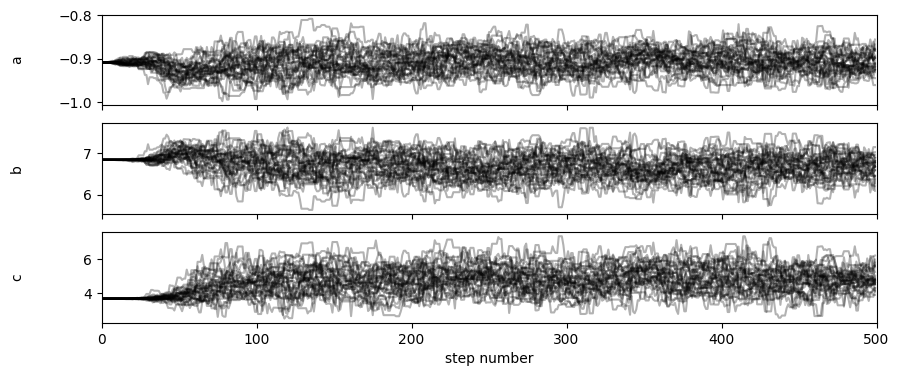

In [55]:
fig, axes = plt.subplots(3, figsize=(10, 4), sharex=True)
samples = sampler.get_chain()
labels = ["a", "b", "c"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [56]:
flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)
print(flat_samples.shape)

(1280, 3)


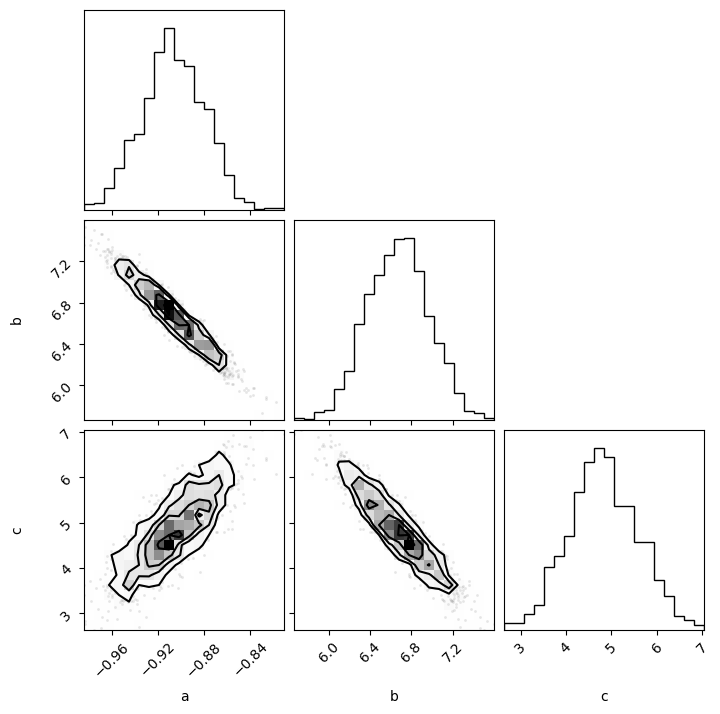

In [57]:
import corner

fig = corner.corner(
    flat_samples, labels=labels
);

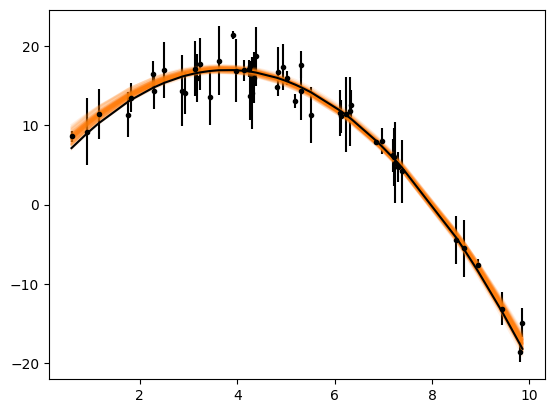

In [58]:
plt.errorbar(x, y, yerr, marker='.', ls='', color='k')
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x,  sample[0] * x ** 2 + sample[1] * x + sample[2], "C1", alpha=0.1)
plt.plot(x, a_true * x ** 2 + b_true * x + c_true, "k", label="truth")